In [2]:
using PyCall
import Plots
Plots.pyplot();

In [3]:
mutable struct IHT
    size::Int64
    overfull_count::Int64
    dictionary::Dict{Any,Any}
    IHT(x) = new(x,0,Dict{Any,Any}())
end

In [4]:
function count(x::IHT)
    return length(x.dictionary)
end
function full(x::IHT)
    return length(x.dictionary >= x.size)
end
function get_index(x::IHT,obj,read_only = false)
    d = x.dictionary
    if haskey(d,obj)
        return d[obj]
    elseif read_only
        return
    end
    size = x.size
    counts = count(x)
    if counts >= size
        if x.overfull_count == 0
            println("IHT full, starting to allow collisions")
        end
        x.overfull_count += 1
        return pybuiltin(:hash)(obj) % x.size
    else
        d[obj] = counts
        return counts
    end
end

get_index (generic function with 2 methods)

In [5]:
function hash_coords(coordinates, m, read_only = false)
    if m isa IHT
        return get_index(m,tuple(coordinates),read_only)
    elseif m isa Number
        return pybuiltin(:hash)(tuple(coordinates)) % m
    else    
        return coordinates
    end
end


hash_coords (generic function with 2 methods)

In [6]:
function tiles(iht_or_size, num_tilings, floats, ints = false, read_only = false)
    if ints == false
        ints = []
    end
    qfloats = [floor(f * num_tilings) for f in floats]
    tiles = []
    for tiling in 1:num_tilings
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q in qfloats
            push!(coords, Int(floor((q+b)/num_tilings)))
            b += tilingX2
        end
        for i in ints
            push!(coords,i)
        end
        for i in hash_coords(coords,iht_or_size,read_only)
            push!(tiles,i+1)
        end
    end
    return tiles
end


tiles (generic function with 3 methods)

In [7]:
# all possible actions
ACTION_REVERSE = 1
ACTION_ZERO = 2
ACTION_FORWARD = 3
# order is important
ACTIONS = [ACTION_REVERSE, ACTION_ZERO, ACTION_FORWARD]

# bound for position and velocity
POSITION_MIN = -1.2
POSITION_MAX = 0.5
VELOCITY_MIN = -0.07
VELOCITY_MAX = 0.07

# use optimistic initial value, so it's ok to set epsilon to 0
EPSILON = 0

0

In [8]:
function step(position, velocity, action)
    new_velocity = velocity + 0.001 * action - 0.0025 * cos(3 * position)
    new_velocity = min(max(VELOCITY_MIN, new_velocity), VELOCITY_MAX)
    
    new_position = position + new_velocity
    new_position = min(max(POSITION_MIN, new_position), POSITION_MAX)
    
    reward = -1.0
    
    if new_position == POSITION_MIN
        new_velocity = 0.0
    end
    return new_position, new_velocity, reward
end

step (generic function with 1 method)

In [9]:
mutable struct ValueFunction
    max_size
    num_of_tilings
    step_size
    hash_table
    weights
    position_scale
    velocity_scale
    function ValueFunction(step_size,num_of_tilings = 8, max_size = 2048)
        max_size = max_size
        num_of_tilings = num_of_tilings
        step_size = step_size / num_of_tilings
        hash_table = IHT(max_size)
        weights = zeros(max_size)
        position_scale = num_of_tilings / (POSITION_MAX - POSITION_MIN)
        velocity_scale = num_of_tilings / (VELOCITY_MAX - VELOCITY_MIN)
        new(max_size, num_of_tilings, step_size, hash_table, weights, position_scale, velocity_scale)
    end
end

In [10]:
function get_active_tiles(self::ValueFunction, position,velocity,action)
    active_tiles = tiles(self.hash_table, self.num_of_tilings,
                            [self.position_scale * position, self.velocity_scale * velocity], [action])
    return active_tiles    
end

get_active_tiles (generic function with 1 method)

In [11]:
function value(self::ValueFunction, position, velocity, action)
    if position == POSITION_MAX
        return 0.0
    end
    active_tiles = get_active_tiles(self,position, velocity, action)
    return sum(self.weights[active_tiles])
end

value (generic function with 1 method)

In [12]:
function learn(self::ValueFunction, position, velocity, action, target)
    active_tiles = get_active_tiles(self,position, velocity, action)
    estimation = sum(self.weights[active_tiles])
    delta = self.step_size * (target - estimation)
    for active_tile in active_tiles
        self.weights[active_tile] += delta
    end
end

learn (generic function with 1 method)

In [13]:
function cost_to_go(self::ValueFunction, position, velocity)
    costs = []
    for action in ACTIONS
        append!(costs,value(self,position, velocity, action))
    end
    return -maximum(costs)
end

cost_to_go (generic function with 1 method)

In [14]:
function get_action(position, velocity, value_function)
    if rand(1)[1] < EPSILON
        action = ACTIONS[rand(1:length(ACTIONS))]
    end
    values = []
    for action in ACTIONS
        push!(values, value(value_function,position,velocity,action))
    end
    choice = []
    for i in enumerate(values)
        if i[2] == maximum(values)
            push!(choice, i[1])
        end
    end
    choice = choice[rand(1:length(choice))]
    return choice
end

get_action (generic function with 1 method)

In [15]:
function semi_gradient_n_step_sarsa(value_function, n = 1)
    current_position = rand() * (-.4 - (-.6)) -.6
    
    current_velocity = 0.0
    
    current_action = get_action(current_position, current_velocity, value_function)
    
    positions = [current_position]
    velocities = [current_velocity]
    actions = [current_action]
    rewards = [0.0]
    
    time = 1
    
    T = 12000
    
    while true
        time += 1
        if time < T
            new_position, new_velocity, reward = step(current_position, current_velocity, current_action)
            new_action = get_action(new_position, new_velocity, value_function)
            
            # track new state and action
            
            push!(positions, new_position)
            push!(velocities, new_velocity)
            push!(actions, new_action)
            push!(rewards, reward)

            if new_position == POSITION_MAX
                T = time
            end
        end
        update_time = time - n
        if update_time >= 0
            returns = 0.0
            # calculate corresponding rewards
            for t in (update_time):(min(T, update_time + n))
                returns += rewards[t]
            end
            
            # add estimated state action value to the return
            if update_time + n <= T
                returns += value(value_function, positions[update_time + n],
                                                 velocities[update_time + n],
                                                 actions[update_time + n])
            end

            # update the state value function
            if positions[update_time] != POSITION_MAX
                learn(value_function,positions[update_time], 
                      velocities[update_time], actions[update_time],
                      returns)
            end
        end
        if update_time == T - 1
            break
        end
        current_position = new_position
        current_velocity = new_velocity
        current_action = new_action
    end
    return time
end

semi_gradient_n_step_sarsa (generic function with 2 methods)

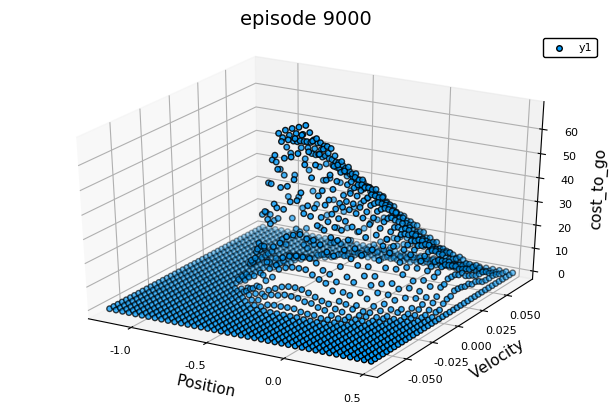

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [16]:
episodes = 9000
plot_episodes = [1,100,episodes/2,episodes]
num_of_tilings = 8
alpha = 0.3
value_function = ValueFunction(alpha, num_of_tilings)
for ep in 1:episodes
    semi_gradient_n_step_sarsa(value_function)
    if ep in plot_episodes
        grid_size = 40
        positions = range(POSITION_MIN, stop = POSITION_MAX, length = grid_size) |> collect
        velocities = range(VELOCITY_MIN, stop = VELOCITY_MAX, length = grid_size) |> collect
        axis_x = []
        axis_y = []
        axis_z = []
        for position in positions
            for velocity in velocities
                push!(axis_x,position)
                push!(axis_y,velocity)
                push!(axis_z,cost_to_go(value_function, position, velocity))
            end
        end
        Plots.scatter(axis_x, axis_y, axis_z,zaxis = "cost_to_go", title =("episode $(ep)"))
        Plots.xaxis!("Position")
        Plots.yaxis!("Velocity")
        Plots.savefig(string(ep))
    end
end

# GRAFICAS
![alt text](1.png "Logo Title Text 1")
![alt text](100.png "Logo Title Text 1")
![alt text](4500.png "Logo Title Text 1")
![alt text](9000.png "Logo Title Text 1")